In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='0'

import fastai
from fastai import *
from fastai.vision import *
from fastai.callbacks.tensorboard import *
from fastai.vision.gan import *
from superRes.generators import *
from superRes.critics import *
from superRes.dataset import *
from superRes.loss import *
from superRes.save import *
from superRes.fid_loss import *
from superRes.ssim import *
from PIL import Image, ImageDraw, ImageFont
from PIL import ImageFile
from pathlib import Path

import torchvision
import geffnet # efficient/ mobile net

In [2]:
def get_data(bs:int, sz:int, keep_pct:float):
    return get_databunch(sz=sz, bs=bs, crappy_path=path_lowRes, 
                         good_path=path_fullRes, 
                         random_seed=None, keep_pct=keep_pct)

def det_DIV2k_data(bs:int, sz:int):
    lowResSuffix = 'x4m'
    src = ImageImageList.from_folder(path_lowRes).split_by_idxs(train_idx=list(range(0,800)), valid_idx=list(range(800,900)))

    data = (src.label_from_func(lambda x: path_fullRes/(x.name).replace(lowResSuffix, '')).transform(
            get_transforms(
                max_zoom=2.
            ),
            size=sz,
            tfm_y=True,
        ).databunch(bs=bs, num_workers=8, no_check=True).normalize(imagenet_stats, do_y=True))
    data.c = 3
    return data

def create_training_images(fn, i, p_hr, p_lr, size):
    """Create low quality images from folder p_hr in p_lr"""
    dest = p_lr/fn.relative_to(p_hr)
    dest.parent.mkdir(parents=True, exist_ok=True)
    img = PIL.Image.open(fn)
    targ_sz = resize_to(img, size, use_min=True)
    img = img.resize(targ_sz, resample=PIL.Image.BILINEAR).convert('RGB')
    img.save(dest, quality=60)

In [3]:
def do_fit(learn, epochs,save_name, lrs=slice(1e-3), pct_start=0.9):
    learn.fit_one_cycle(epochs, lrs, pct_start=pct_start)
    learn.save(save_name)
    learn.show_results(rows=1, imgsize=5)

In [4]:
path = Path('./dataset/')

path_fullRes = path/'DIV2K_train_HR'
path_lowRes = path/'DIV2K_train_LR_mild'

proj_id = 'unet_superRes_mobilenetV3_SSIM'

gen_name = proj_id + '_gen'
crit_name = proj_id + '_crit'

nf_factor = 2
pct_start = 1e-8

In [5]:
print(path_lowRes)

dataset/DIV2K_train_LR_mild


In [6]:
model = geffnet.mobilenetv3_100
# model = models.resnet34
# model= geffnet.efficientnet_b4

# 256px

In [7]:
bs=10
sz=256
lr = 1e-2
wd = 1e-3
epochs = 5

In [8]:
data_gen = det_DIV2k_data(bs=bs, sz=sz)

In [9]:
# data_gen.show_batch(ds_type=DatasetType.Valid, rows=1, figsize=(9,9))

In [10]:
# loss_func = FeatureLoss()
loss_func = ssim
# loss_func = calculate_frechet_distance

In [11]:
learn_gen = gen_learner_wide(data=data_gen,
                             gen_loss=loss_func,
                             arch = model,
                             nf_factor=nf_factor)

In [12]:
wandbCallbacks = False

if wandbCallbacks:
    wandb.init(project='SuperRes', id="gen_128")

    wandb.config.batch_size = bs
    wandb.config.img_size = (sz, sz)
    wandb.config.learning_rate = lr
    wandb.config.weight_decay = wd
    wandb.config.num_epochs = epochs
    
    learn_gen.callback_fns.append(partial(WandbCallback, input_type='images'))

In [13]:
# learn_gen.lr_find()
# learn_gen.recorder.plot()
# learn_gen.summary()

epoch,train_loss,valid_loss,time
0,0.872366,0.736142,01:47
1,0.718092,0.644433,01:36
2,0.670183,0.623627,01:38
3,0.655088,0.631442,01:38
4,0.640164,0.607526,01:41


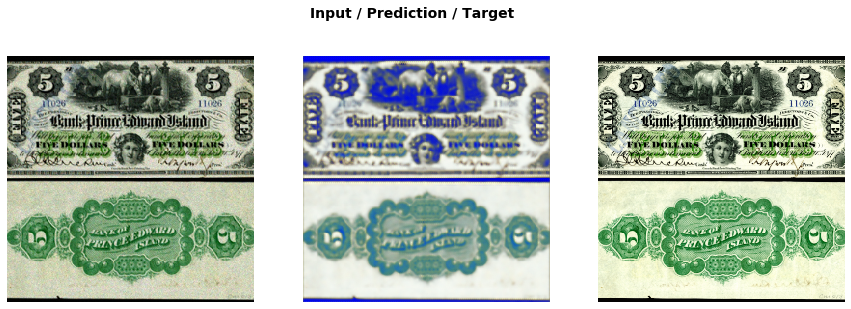

In [14]:
do_fit(learn_gen, epochs, gen_name+"_256px_0", slice(lr*10))

In [15]:
learn_gen.unfreeze()

In [ ]:
do_fit(learn_gen, 3, gen_name+"_256px_1", slice(lr))

epoch,train_loss,valid_loss,time


# 512px

In [ ]:
bs=4
sz=512
epochs = 5

In [ ]:
data_gen = det_DIV2k_data(bs, sz)

In [ ]:
learn_gen.data = data_gen
learn_gen.freeze()
gc.collect()

In [ ]:
learn_gen.load(gen_name+"_256px_1")

In [ ]:
learn_gen.lr_find()
learn_gen.recorder.plot()

In [ ]:
print("Upsize to gen_512")

do_fit(learn_gen, epochs, gen_name+"_512px_0",slice(1e-6))

In [ ]:
learn_gen.unfreeze()

In [ ]:
do_fit(learn_gen, 1, gen_name+"_512px_1", slice(lr))

In [ ]:
learn_gen = None
gc.collect()